# Estimate the number of borrow events missing from the dataset.

Borrow events almost exclusively tracked through the circulation cards, but how many cards survived is unknown and varies dramatically with time (i.e. cards that existed in the 1940s were likely to be preserved than those in the 1920s). With this in mind can we estimate the total circulation?

Notes
* We will focus exclusively on dates prior to 1942, which leaves out approximately 2 percent
* Only subscription events with solid start and end dates will be used in calculating the borrow event estimate. This excludes six percent of subscription events.

In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
MISSING_MEMBERS_ESTIMATE = 0.9118

In [3]:
csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])

# Create borrow events summary

In [4]:
# How many borrow events do we have?
borrow_events = events_df[events_df['event_type'] == 'Borrow']
borrow_events.shape[0]

21061

In [5]:
# How many borrow events come from logbooks
borrow_events[borrow_events['source_type'] == 'Logbook'].shape[0]

21

In [6]:
# How many borrow events with unknown dates are there?
print(borrow_events.start_date.isna().sum())
# Let's drop them
borrow_events = borrow_events.dropna(subset=['start_date'])

81


In [7]:
# How many borrow events occur after 1942?
borrow_events['start_date'] = pd.to_datetime(borrow_events['start_date'], errors='coerce')
borrow_events = borrow_events.dropna(subset=['start_date'])
borrow_events_after_1942 = borrow_events[borrow_events['start_date'] >= datetime(1942, 1, 1)]
borrow_events_after_1942.shape[0]

410

In [8]:
# What proportion of the data occurs here?
print(round(borrow_events_after_1942.shape[0] / borrow_events.shape[0] * 100, 2))
# Let's drop these events after 1942
borrow_events = borrow_events[borrow_events['start_date'] < datetime(1942, 1, 1)]

1.96


In [9]:
# What percent of members have a card?
round(members_df[members_df['has_card']].shape[0] / members_df.shape[0] * 100, 2)

11.66

# How constant are subscription habits?

Ideally, we'd be able to extrapolate from the borrowing rates of the cards that we have to estimate how many borrowing events we don't have.


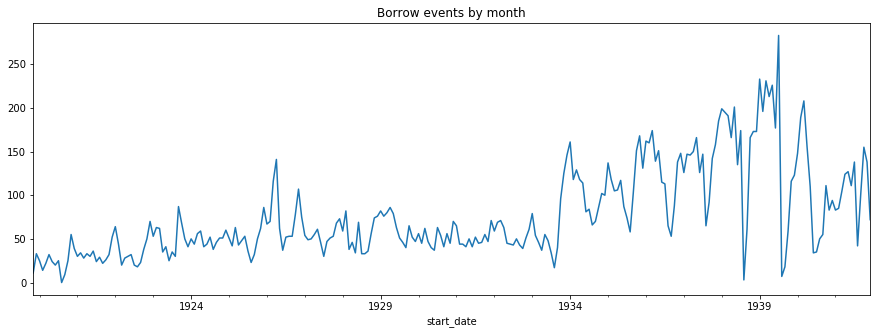

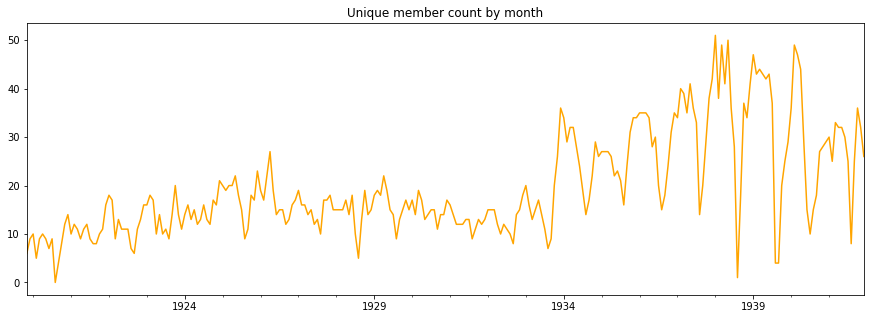

In [10]:
monthly_count = borrow_events.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()
monthly_count.plot(figsize=(15, 5), title='Borrow events by month')

# for each month get the count of the unique active members
monthly_groups = borrow_events.groupby([pd.Grouper(key='start_date', freq='M')])
member_count = []
for i, df in monthly_groups:
    member_count.append([i, df['member_uris'].unique().shape[0]])
    
member_count_df = pd.DataFrame([x[1] for x in member_count], index=pd.to_datetime([x[0] for x in member_count]))
member_count_df.plot(figsize=(15, 5), legend=False, title='Unique member count by month', color='orange')

**Given the consistency between these two graphs we can largely extrapolate that the reading habits of active members was largely consistent**

count    265.000000
mean       3.763287
std        0.930628
min        1.750000
25%        3.076923
50%        3.705882
75%        4.307692
max        7.648649
Name: borrow_event_per_active_member, dtype: float64


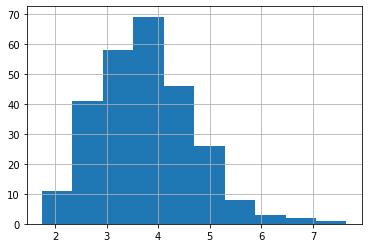

In [11]:
# Get the proportion of borrow events per active member
member_count_df.columns = ['member_count']
member_count_df['borrow_events'] = monthly_count
member_count_df['borrow_event_per_active_member'] = member_count_df['borrow_events'] / member_count_df['member_count']

print(member_count_df['borrow_event_per_active_member'].describe())
member_count_df['borrow_event_per_active_member'].hist()

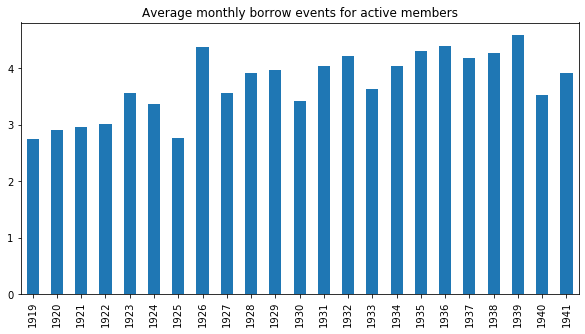

In [12]:
# Going by month seems overkill, let's group by year
proportion_by_year = member_count_df['borrow_event_per_active_member'].groupby([pd.Grouper(freq='Y')]).mean()
proportion_by_year.index = proportion_by_year.index.year
ax = proportion_by_year.plot(kind='bar', title='Average monthly borrow events for active members', figsize=(10, 5))
ax

# Apply reading habits to monthly membership


In [13]:
# How many unique active members are mentioned each month in the logbooks?
subscription_events = events_df[events_df['event_type'].isin(['Subscription', 'Renewal', 'Supplement'])]
subscription_events['start_date'] = pd.to_datetime(subscription_events.start_date, errors='coerce')
subscription_events['end_date'] = pd.to_datetime(subscription_events.end_date, errors='coerce')

# How many null values occur in start or end date?
print(subscription_events.start_date.isna().sum())
print(subscription_events.end_date.isna().sum())
# Drop these
subscription_events = subscription_events.dropna(subset=['start_date', 'end_date'])

11
646


In [38]:
def active_count(df_t, d):
    return df_t[(df_t.start_date <= d) & (df_t.end_date >= d)].shape[0]

monthly_membership_count = {}
month_range = pd.date_range('1919-11-01','1941-12-01', freq='MS').tolist()
for month in month_range:
    monthly_membership_count[month] = active_count(subscription_events, month)
    
estimated_borrow_count = {}
for stamp, count in monthly_membership_count.items():
    estimated_borrow_count[stamp] = 3.7 * count/ MISSING_MEMBERS_ESTIMATE # proportion_by_year[stamp.year]*count

Text(0.5, 0, '')

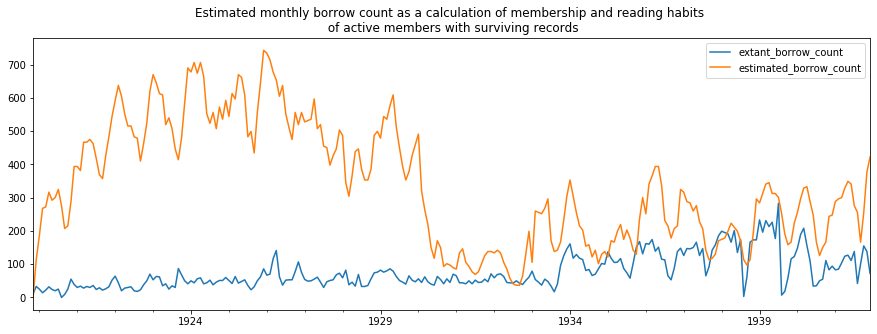

In [39]:
comparison_df = pd.DataFrame(monthly_count)
comparison_df.columns = ['extant_borrow_count']
comparison_df['estimated_borrow_count'] = estimated_borrow_count.values()
ax = comparison_df.plot(figsize=(15, 5), title='Estimated monthly borrow count as a calculation of membership and reading habits \n of active members with surviving records')
ax.set_xlabel('')

In [40]:
comparison_df['extant_borrow_count'].sum()

20513

In [41]:
# What is the estimated number of missing borrow events
missing_borrow_event_estimate = comparison_df['estimated_borrow_count'].sum() 
round(missing_borrow_event_estimate)

89457.0

In [51]:
# What proportion of the estimated borrow events are contained in the dataset
round(comparison_df['extant_borrow_count'].sum() / missing_borrow_event_estimate * 100, 2)

22.93